In [1]:
import csv

# Generate filenames programmatically
path = "/Volumes/Kingston XS2000 Media/XGBoost_OD_TBBE/XGBoostTBBE/1000simXgb1Data" # 5 xgb1 not 10 
files = [path + "/getXGBoost2TrainingData_{}.csv".format(i) for i in range(1000)]

merged_filename = "/Volumes/Kingston XS2000 Media/XGBoost_OD_TBBE/XGBoostTraining/dataXgb2Training3/XGB2_merged_result.csv"

with open(merged_filename, "w", newline="") as outfile:
    writer = csv.writer(outfile)

    for index, filename in enumerate(files):
        with open(filename, "r") as infile:
            reader = csv.reader(infile)

            # Skip header only if it's not the first file
            if index != 0:
                next(reader, None)

            # Write rows from current file to the output file
            writer.writerows(reader)

In [2]:
import pandas as pd

# Read the merged CSV file into a DataFrame
df = pd.read_csv(
    "/Volumes/Kingston XS2000 Media/XGBoost_OD_TBBE/XGBoostTraining/dataXgb2Training3/XGB2_merged_result.csv"
)

# Sort the DataFrame by balance in descending order
df_sorted = df.sort_values(by="balance", ascending=False)

df_sorted.head(100)

,type,competitorID,time,exchange,odds,agentID,stake,distance,rank,balance,decision
2254367,Trade,4,31.499081,0,2.444616,50,15,267.278012,4,1.000142e+08,layer
2254997,Trade,4,44.401221,0,1.782831,50,15,397.614161,4,1.000142e+08,layer
2252923,Trade,4,2.656144,0,2.789266,50,15,17.764827,2,1.000142e+08,layer
2252925,Trade,4,2.667647,0,4.110982,50,15,17.764827,2,1.000142e+08,layer
2252929,Trade,4,2.684332,0,4.104707,50,15,17.764827,2,1.000142e+08,layer
...,...,...,...,...,...,...,...,...,...,...,...
2253021,Trade,4,3.378237,0,2.813015,50,15,24.948385,3,1.000142e+08,layer
2253025,Trade,4,3.406971,0,3.502571,50,15,24.948385,3,1.000142e+08,layer
2253033,Trade,4,3.455639,0,3.434558,50,15,24.948385,3,1.000142e+08,layer
2253085,Trade,4,3.836680,0,3.380006,50,15,24.948385,3,1.000142e+08,layer


In [3]:
# Calculate 20% of the total number of rows and retrieve the top rows
top_20_percent = int(0.20 * len(df_sorted))
top_20_df = df_sorted.head(top_20_percent)

# Save the top 20% rows to a new CSV file, if desired
top_20_df.to_csv(
    "/Volumes/Kingston XS2000 Media/XGBoost_OD_TBBE/XGBoostTraining/dataXgb2Training3/XGB2_Top_20%.csv",
    index=False,
)

In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Import the data
data = pd.read_csv(
    "/Volumes/Kingston XS2000 Media/XGBoost_OD_TBBE/XGBoostTraining/dataXgb2Training3/XGB2_Top_20%.csv"
)
decision_counts = data["decision"].value_counts()
print(decision_counts)
# 2. Preprocessing

# Remove potentially irrelevant columns
data = data.drop(
    columns=["type", "competitorID", "exchange", "agentID", "balance", "odds"]
)

# Column that has left: time  odds  stake  distance  rank

# Convert 'decision' column to binary: 1 for 'backer' and 0 for 'layer'
data["decision"] = data["decision"].map({"backer": 1, "layer": 0})

# Split data into training and testing sets
X = data.drop(columns="decision")
print(X.head())
y = data["decision"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

decision
layer     414294
backer    129723
Name: count, dtype: int64
        time  stake    distance  rank
0  31.499081     15  267.278012     4
1  44.401221     15  397.614161     4
2   2.656144     15   17.764827     2
3   2.667647     15   17.764827     2
4   2.684332     15   17.764827     2


In [6]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from tqdm import tqdm
from joblib import Parallel, delayed

# More hyperparam vals added
param_grid = {
    "eta": [0.3, 0.4],  # Default: 0.3
    "max_depth": [6, 7],  # Default: 6
    "subsample": [1.0],  # Default: 1
    "colsample_bytree": [1.0],  # Default: 1
    "gamma": [0,0.1],  # Default: 0
    "alpha": [0, 0.1, 0.2, 0.3],  # Default: 0
    "lambda": [0.5, 1, 1.5, 2],  # Default: 1
    
}
# Convert the booster to scikit-learn format
xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_estimators=100,
)
# Set up grid search
grid_search = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=4,  # Use all available cores
    cv=5, # was 2
    verbose=2,
)
# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best model for prediction and evaluation
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy (Best Model):", accuracy_best)
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END alpha=0, colsample_bytree=1.0, eta=0.3, gamma=0, lambda=0.5, max_depth=6, subsample=1.0; total time=   5.9s
[CV] END alpha=0, colsample_bytree=1.0, eta=0.3, gamma=0, lambda=0.5, max_depth=6, subsample=1.0; total time=   5.9s
[CV] END alpha=0, colsample_bytree=1.0, eta=0.3, gamma=0, lambda=0.5, max_depth=6, subsample=1.0; total time=   6.1s
[CV] END alpha=0, colsample_bytree=1.0, eta=0.3, gamma=0, lambda=0.5, max_depth=6, subsample=1.0; total time=   6.1s
[CV] END alpha=0, colsample_bytree=1.0, eta=0.3, gamma=0, lambda=0.5, max_depth=6, subsample=1.0; total time=   6.7s
[CV] END alpha=0, colsample_bytree=1.0, eta=0.3, gamma=0, lambda=0.5, max_depth=7, subsample=1.0; total time=   8.5s
[CV] END alpha=0, colsample_bytree=1.0, eta=0.3, gamma=0, lambda=0.5, max_depth=7, subsample=1.0; total time=   9.0s
[CV] END alpha=0, colsample_bytree=1.0, eta=0.3, gamma=0, lambda=0.5, max_depth=7, subsample=1.0; total time=   9.4s
[

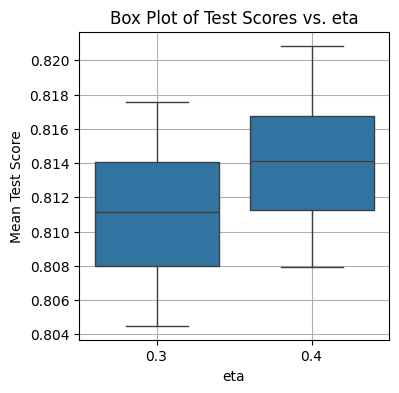

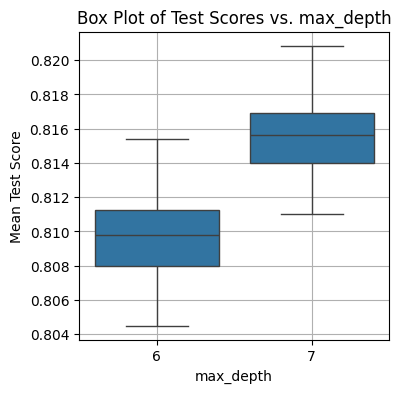

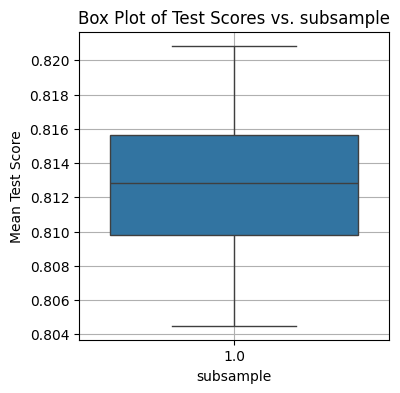

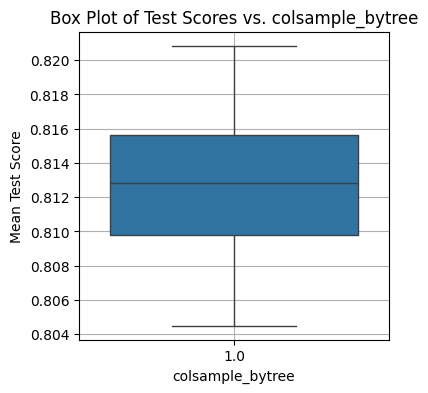

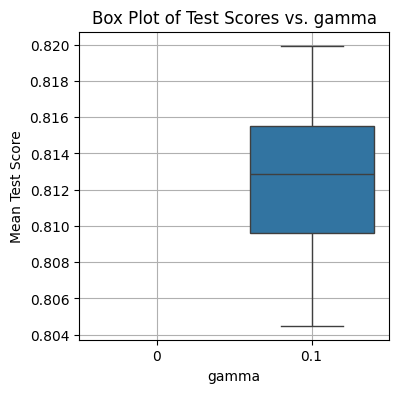

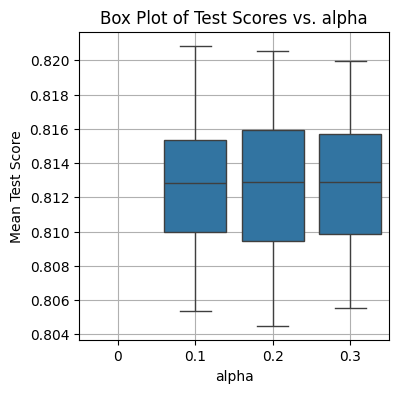

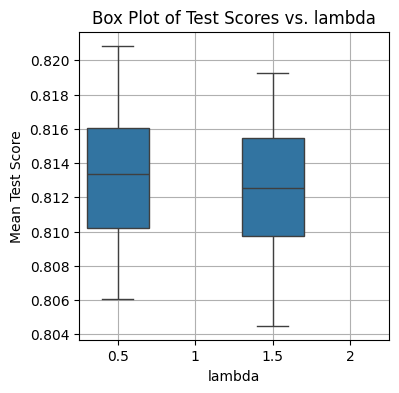

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the grid search results to a dataframe
results_df = pd.DataFrame(grid_search.cv_results_)

for param in param_grid.keys():
    plt.figure(figsize=(4, 4))

    # Extract individual fold scores
    fold_scores = [results_df[f"split{i}_test_score"] for i in range(grid_search.cv)]
    fold_scores_df = pd.concat(fold_scores, axis=1)

    # Extract parameter values and add as a new column
    fold_scores_df[param] = results_df["param_" + param]

    # Melt the dataframe for seaborn
    melted_scores_df = fold_scores_df.melt(
        id_vars=param,
        value_vars=[f"split{i}_test_score" for i in range(grid_search.cv)],
        var_name="cv_fold",
        value_name="score",
    )

    # Boxplot
    sns.boxplot(data=melted_scores_df, x=param, y="score")
    plt.title(f"Box Plot of Test Scores vs. {param}")
    plt.ylabel("Mean Test Score")
    plt.grid(True)
    plt.show()

Accuracy: 0.8193081136722915

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89     82867
           1       0.75      0.36      0.49     25937

    accuracy                           0.82    108804
   macro avg       0.79      0.66      0.69    108804
weighted avg       0.81      0.82      0.79    108804



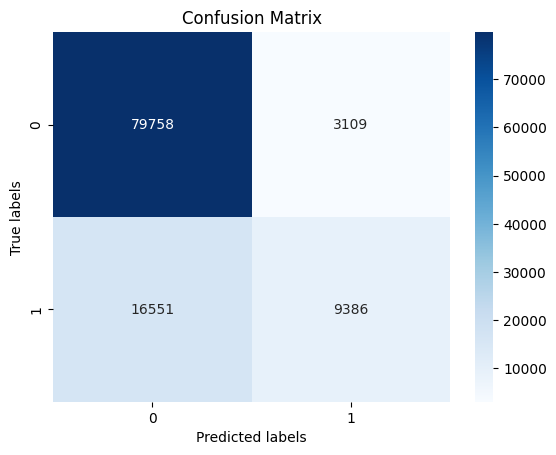

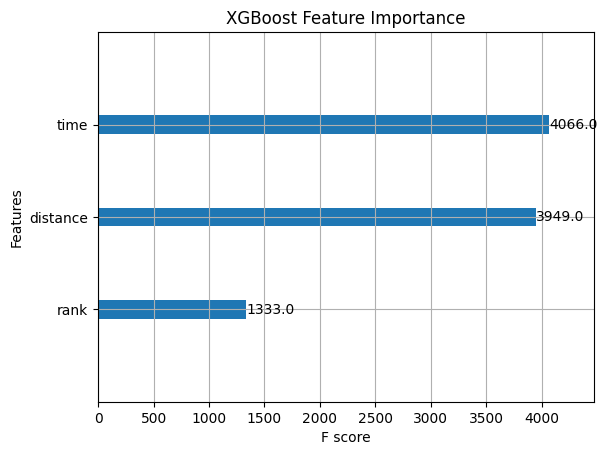

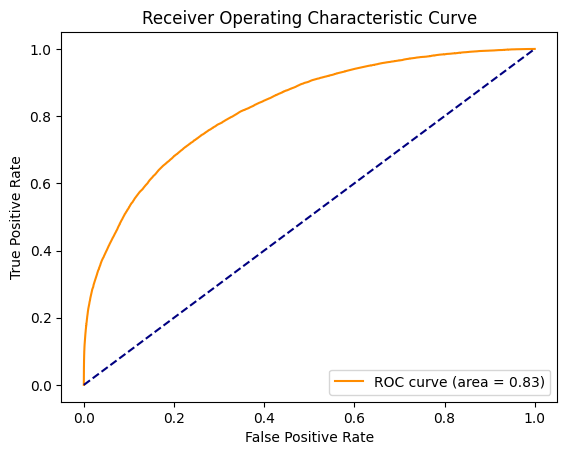

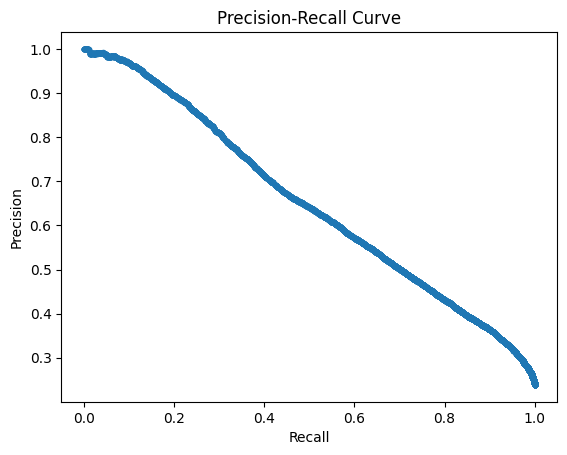

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
import seaborn as sns
import joblib

# 1. Testing on the Test Set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 2. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# 3. Visualization

# Feature Importance
xgb.plot_importance(best_model)
plt.title("XGBoost Feature Importance")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

<Figure size 2000x1500 with 0 Axes>

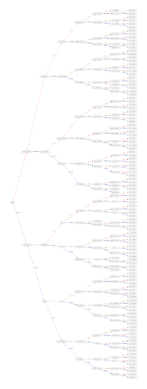

In [9]:
import matplotlib.pyplot as plt

# Plot first tree from the model
import os

os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"
# Plot the first tree
plt.figure(figsize=(20, 15))
xgb.plot_tree(best_model, num_trees=0, rankdir="LR")
plt.show()

{'alpha': 0.3, 'colsample_bytree': 1.0, 'eta': 0.4, 'gamma': 0.1, 'lambda': 0.5, 'max_depth': 7, 'subsample': 1.0}


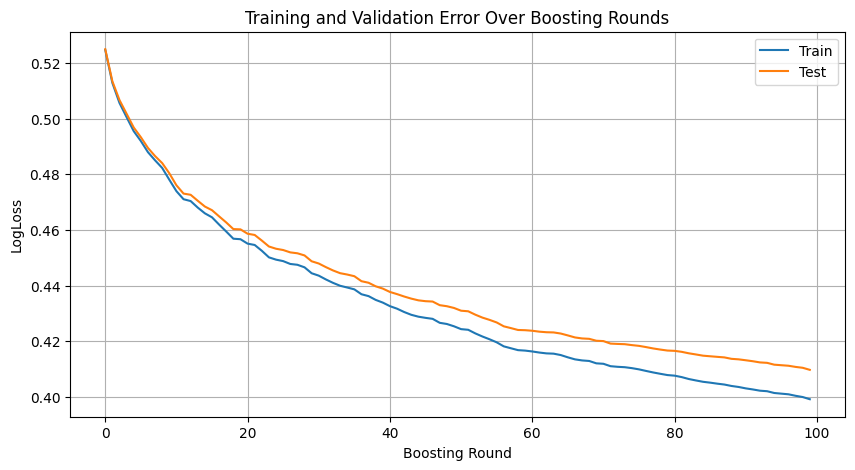

In [9]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Use the best parameters from the grid search
best_params = grid_search.best_params_
print(best_params)

# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_estimators=100,
    **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_estimators=1000,  # Increasing n_estimators
    **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=10,  # Adding early stopping
    verbose=False,
)

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(alpha=0.3, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.4, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0.5,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000, ...)

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


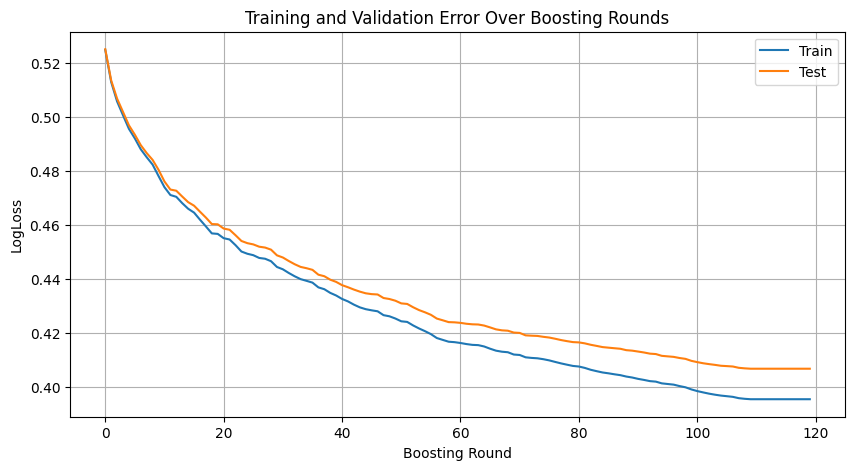

In [11]:
# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=False
)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best iteration: 109


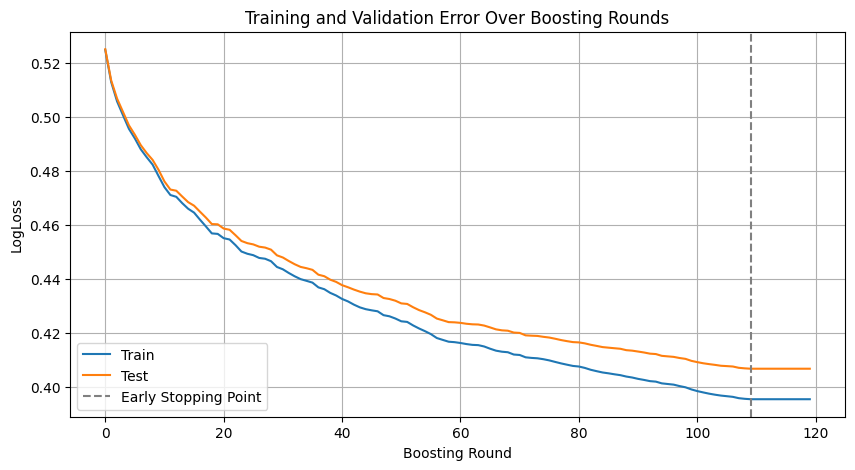

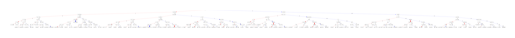

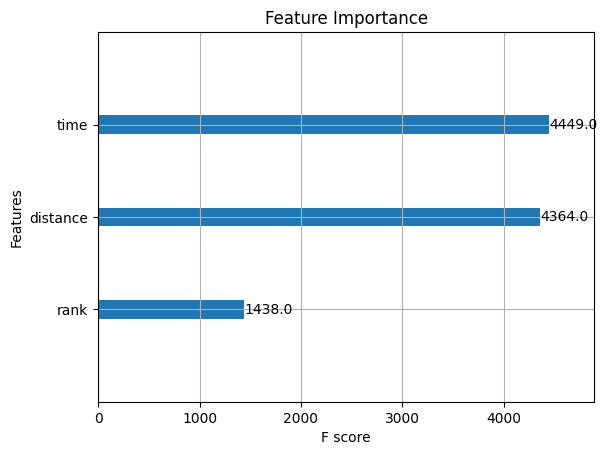

    Feature  Importance
3      rank    0.430062
2  distance    0.290333
0      time    0.279605
1     stake    0.000000


In [12]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=False
)

# 1. Print the boosting round where early stopping occurred:
print(f"Best iteration: {best_xgb_estimator.get_booster().best_iteration}")
# print(f"Best ntree_limit: {best_xgb_estimator.get_booster().best_ntree_limit}")

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.axvline(
    x=best_xgb_estimator.get_booster().best_iteration,
    color="gray",
    linestyle="--",
    label="Early Stopping Point",
)
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

# 2. Visualize the model using XGBoost's plot functionalities:

# a. Plotting the first tree:
xgb.plot_tree(best_xgb_estimator, num_trees=0)
plt.show()

# b. Displaying the importance of each feature:
xgb.plot_importance(best_xgb_estimator)
plt.title("Feature Importance")
plt.show()

# If you'd like a table of feature importances:
importances = best_xgb_estimator.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame(
    {"Feature": features, "Importance": importances}
).sort_values(by="Importance", ascending=False)
print(feature_importance_df)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     82867
           1       0.75      0.37      0.49     25937

    accuracy                           0.82    108804
   macro avg       0.79      0.66      0.69    108804
weighted avg       0.81      0.82      0.80    108804

[[79740  3127]
 [16448  9489]]


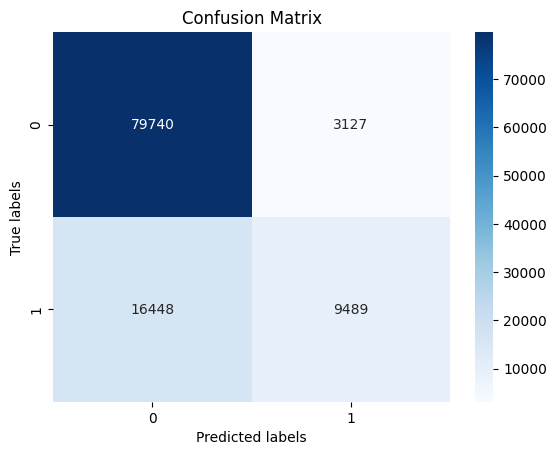

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Predict the classes
y_pred = best_xgb_estimator.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Visualizing the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

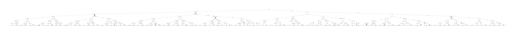

In [16]:
xgb.plot_tree(best_xgb_estimator, num_trees=0, max_depth=4)
plt.show()

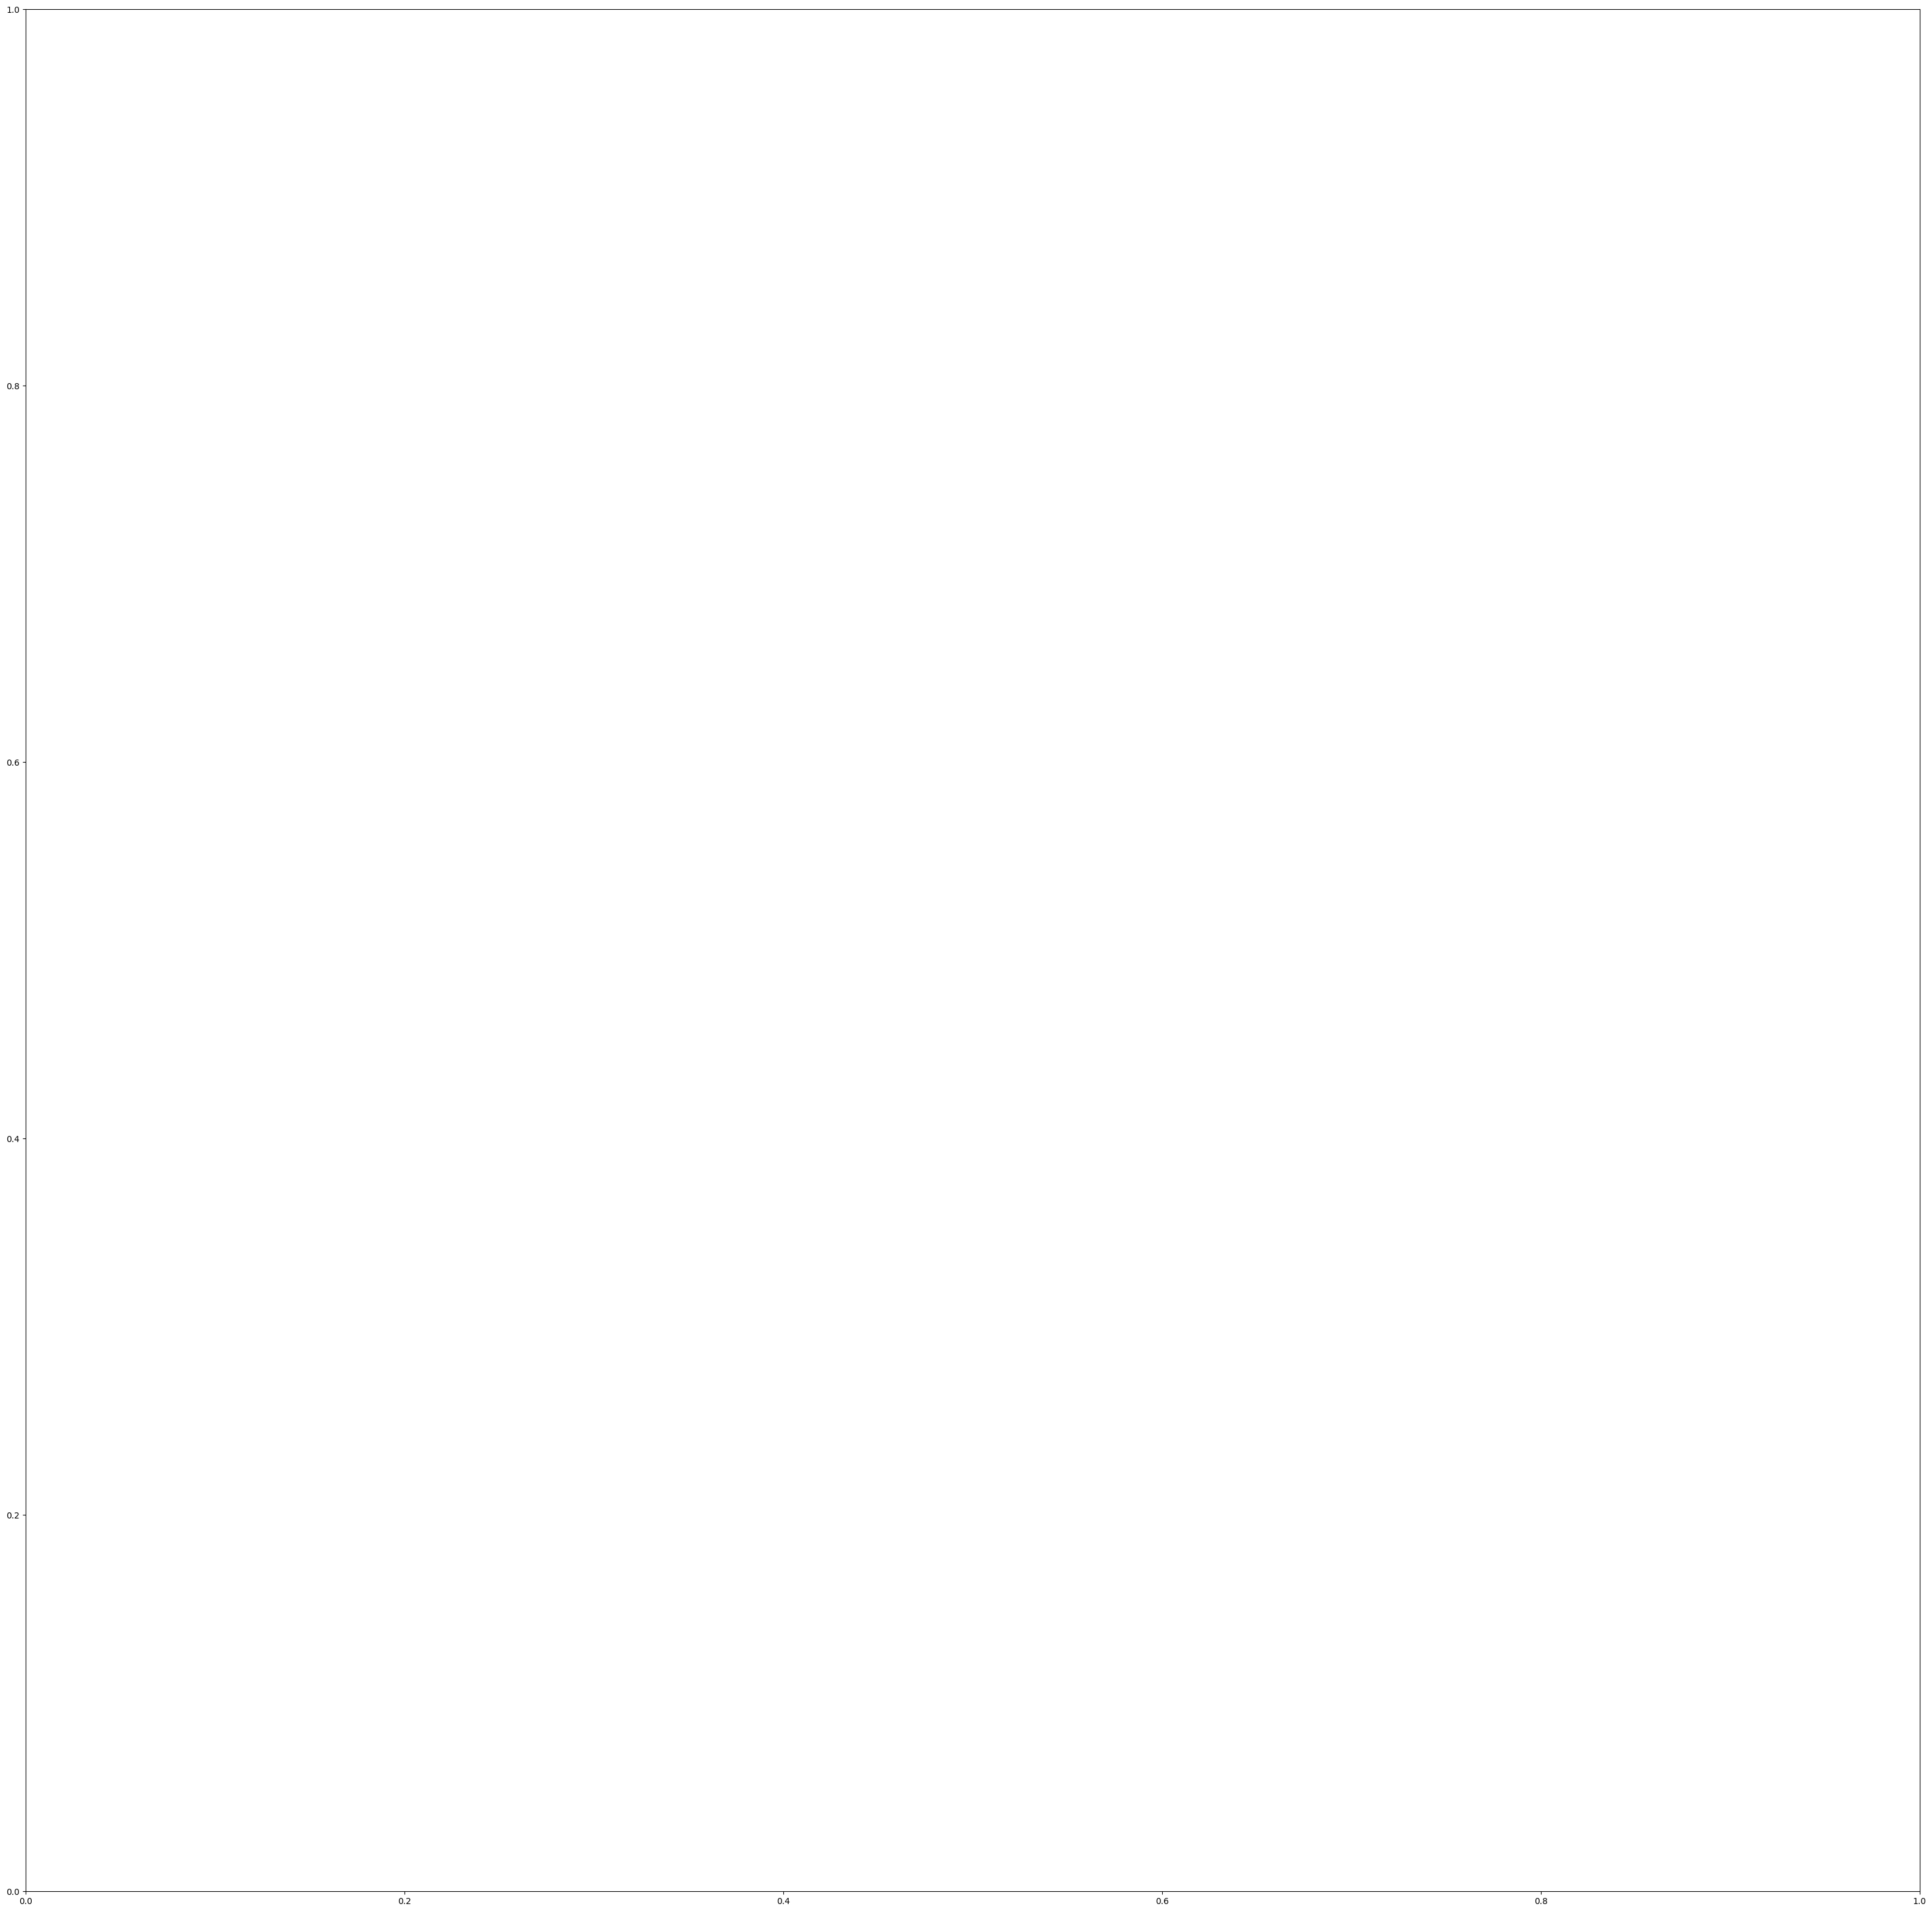

In [17]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Define figure size and resolution
fig, ax = plt.subplots(figsize=(40, 40))

# Plotting the tree with the max_depth option
xgb.plot_tree(best_xgb_estimator, num_trees=0, rankdir="LR")

# Saving the plot with increased resolution
plt.savefig("xgboost_tree1.png", dpi=600)
plt.close()

In [26]:
# Save the best model to a .json file
best_model.get_booster().save_model("Trained_XGB2_model3.json")